In [1]:
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import time
import os
import datetime
import collections
import re
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HaomingSun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HaomingSun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
9737it [02:52, 56.36it/s]
1636it [00:00, 11944.80it/s]


train_set MSE: 0.0006563472367326087
test_set MSE: 0.7032509602986257


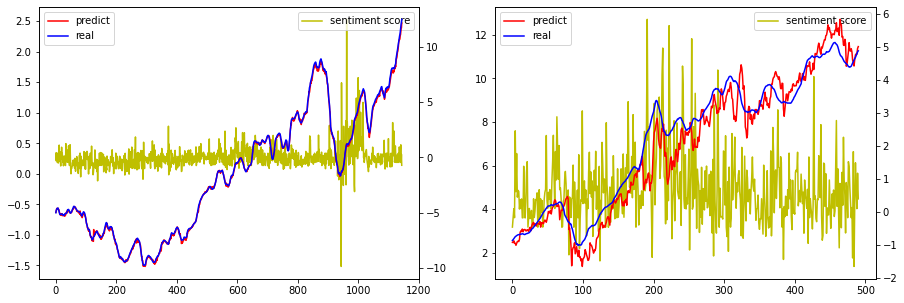

train_set MSE: 0.016362363242212134
test_set MSE: 0.22455346433143306


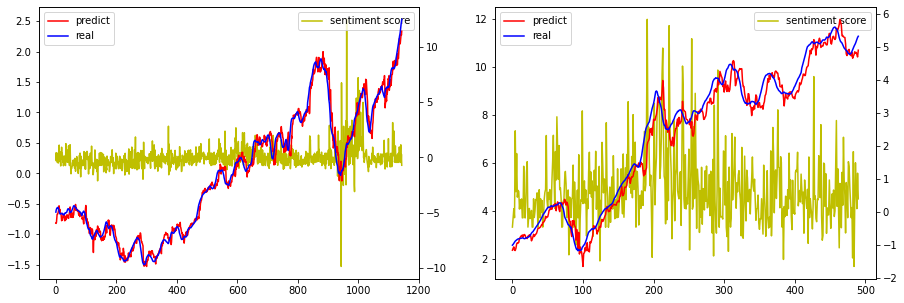

train_set MSE: 0.639466136255969
test_set MSE: 54.548439435140395


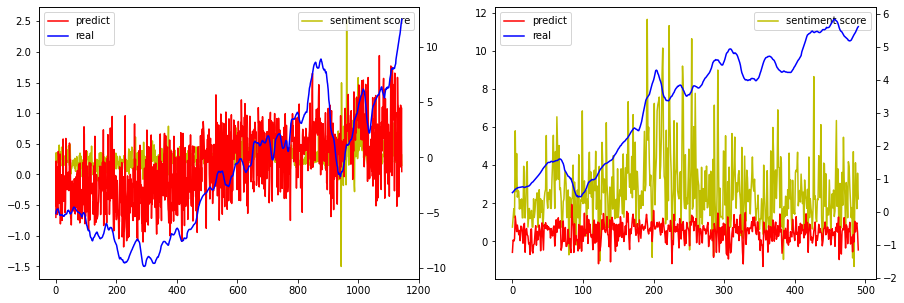

train_set MSE: 0.001231488325362262
test_set MSE: 0.8281576432497889


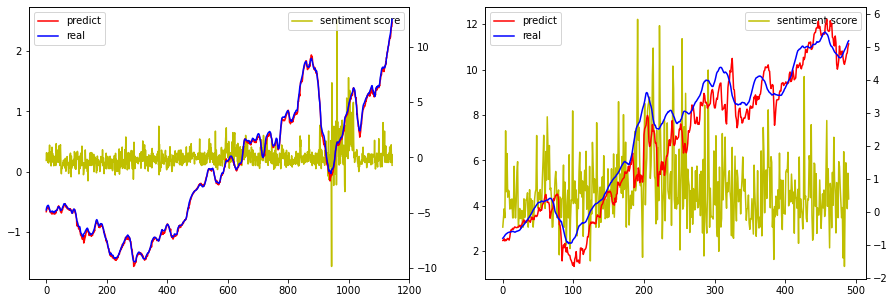

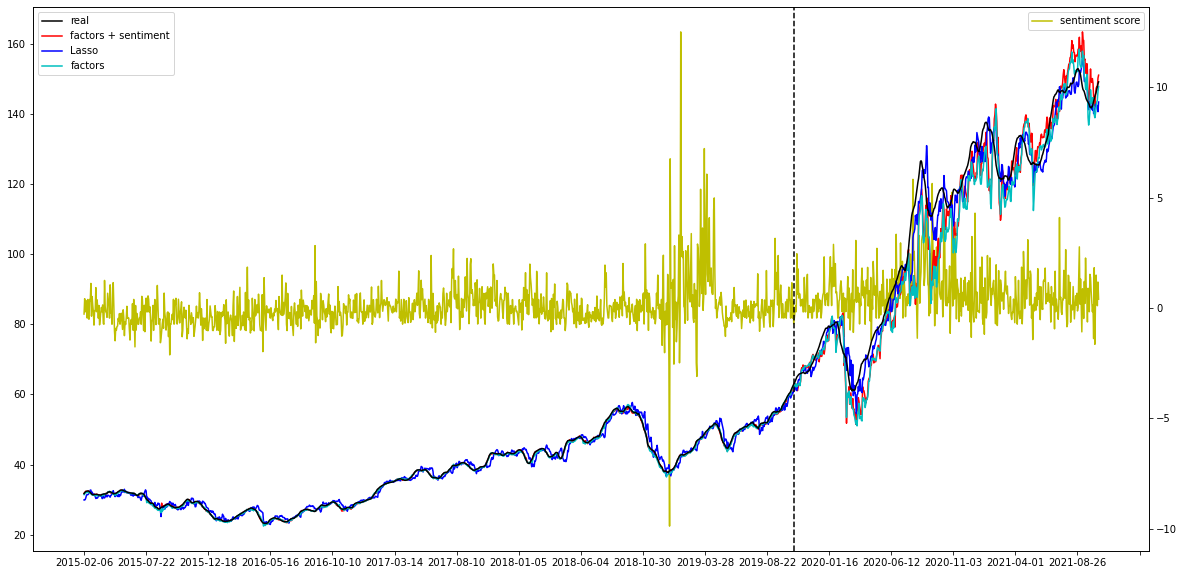

In [2]:
# Regression experiment using NLTK SentimentIntensityAnalyzer
nltk.download('punkt')

lancaster=LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def load_nltk_data_set(stock):
    nltk.download('vader_lexicon')
    regEx = re.compile('\W')
    new_words =  {'falls': -9, 'drops': -9, 'rise': 9, 'increases': 9, 'gain': 9, 'hiked': -9, 'dips': -9, 'declines': -9, 'decline': -9, 'hikes': -9, 'jumps': 9,
                  'lose': -9, 'profit': 9, 'loss': -9, 'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9, 'rupee weakens': -9, 'record low': -9, 'record high': 9,
                  'sensex up': 9, 'down': -9, 'sensex down': -9, 'up': 9,'forbidden':-9,'crackdown':-9,'tougher':-9,'bans':-9,'restrictions':-9,'ban':-9,'restriction':-9,
                  'stricter':-9, 'worst':-9,'deprive':-9, 'hardly':-9,'limiting':-9,'enacting':-9,'fear':-9,'little':-9,'resist':-9,'contrarian':-9,'cold':-9,
               'danger':-9,'lurks':-9,'fining':-9,'decimate':-9} 

    f_list = []

    analyser = SentimentIntensityAnalyzer()
    analyser.lexicon.update(new_words)
    his = pd.read_csv('./stock_data_new/'+stock+'.csv',index_col='Date')
    news = pd.read_csv('./news_data/'+stock+'.csv',encoding='utf_8_sig')
    news['date'] = news['date'].apply(lambda x:x[:10])
    news = news.sort_values(by ='date',ignore_index=True)
    for i,row in tqdm(news.iterrows()):
        day = row['date']
        try:
            temp = his.loc[day]
        except:
            if i-1<0:
                continue
            news.at[i,'date'] = news.iloc[i-1]['date']
            day = news.iloc[i-1]['date']
            try:
                temp = his.loc[day]
            except:
                continue
            
        news_test = stemSentence(row['news'])
        score = analyser.polarity_scores(news_test)
        news.at[i,'score_g'] = score['neg']
        news.at[i,'score_p'] = score['pos']
        news.at[i,'score_n'] = score['neu']
        news.at[i,'compound'] = score['compound']
        news.at[i,'length'] = 1

    news['score_g_total'] = news.groupby(['date'])['score_g'].transform(lambda x: sum(x))
    news['score_p_total'] = news.groupby(['date'])['score_p'].transform(lambda x: sum(x))
    news['score_n_total'] = news.groupby(['date'])['score_n'].transform(lambda x: sum(x))
    news['length_total'] = news.groupby(['date'])['length'].transform(lambda x: sum(x))
    news['score_ralative'] = news.groupby(['date'])['compound'].transform(lambda x: sum(x))
    news.to_csv(stock+'_news_test.csv')
    news = news[['date','score_g_total','score_p_total','score_n_total','score_ralative','length_total']]
    news.drop_duplicates(inplace = True)

    news.sort_values(by='date',ignore_index=True)
    news = news.reset_index(drop = True)

    for i,row in tqdm(news.iterrows()):
        day = row['date']
        his.at[day,'score_ralative'] = row['score_ralative']
        his.at[day,'score_g'] = row['score_g_total']
        his.at[day,'score_n'] = row['score_n_total']
        his.at[day,'score_p'] = row['score_p_total']
        
    his = his.loc[news['date']]
    his.to_csv(stock+'.csv')

    return his

def uni(a):
    return (a-np.mean(a))/np.std(a)

x_train,x_test,y_train,y_test = [],[],[],[]
show_aapl_x_train = []
show_aapl_x_test = []
show_aapl_y_train = []
show_aapl_y_test = []
show_date_train =[]
show_date_test = []
#for stock in ['amzn','tal','baba','googl','tsla','aapl','dis','fb','nflx','nvda','uber','se']:
for stock in ['aapl']:
    his = load_nltk_data_set(stock)
    his= his.dropna(axis=0, how='any')
    
    feature = np.array(his)

    x_feature = feature[:-1,1:-48].copy()
    # -3,-18,-33,-48 represent 1(5,10,21)-day avg line after 1/(5,10,21) day, respectively.
    y_feature = feature[1:,-18].copy() 
    
    x_train_feature,x_test_feature = x_feature[:int(x_feature.shape[0]*0.7),:],x_feature[int(x_feature.shape[0]*0.7):,:]
    y_train_feature,y_test_feature = y_feature[:int(y_feature.shape[0]*0.7)],y_feature[int(y_feature.shape[0]*0.7):]
    
    x_train.append(x_train_feature)
    x_test.append(x_test_feature)
    y_train.append(y_train_feature)
    y_test.append(y_test_feature)
    
    if stock == 'aapl': # we save the data of Apple for visualization
        date_array = his.index.tolist()
        date_array = np.array(date_array[1:])
        show_date_train,show_date_test=date_array[:int(date_array.shape[0]*0.7)],date_array[int(date_array.shape[0]*0.7):]
        show_aapl_x_train=x_train_feature
        show_aapl_x_test=x_test_feature
        show_aapl_y_train=y_train_feature
        show_aapl_y_test=y_test_feature
    
    

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)


for i in range(x_train.shape[1]):
    show_aapl_x_train[:,i] = (show_aapl_x_train[:,i]-np.mean(x_train[:,i]))/np.std(x_train[:,i])
    show_aapl_x_test[:,i] = (show_aapl_x_test[:,i]-np.mean(x_train[:,i]))/np.std(x_train[:,i])
    x_test[:,i] = (x_test[:,i]-np.mean(x_train[:,i]))/np.std(x_train[:,i])
    x_train[:,i] = (x_train[:,i]-np.mean(x_train[:,i]))/np.std(x_train[:,i])

y_avg = np.mean(y_train)
y_std = np.std(y_train)
    
y_test = (y_test-np.mean(y_train))/np.std(y_train)
y_train = (y_train-np.mean(y_train))/np.std(y_train)

fitL = Lasso(alpha=0.0001,max_iter=500000)
fit1 = MLPRegressor(hidden_layer_sizes = (128,512,512,64),learning_rate='adaptive',activation = 'relu',solver = 'adam',alpha = 0.01, max_iter = 1000000000,learning_rate_init=0.001)
fit2 = MLPRegressor(hidden_layer_sizes = (128,512,512,64),learning_rate='adaptive',activation = 'relu',solver = 'adam',alpha = 0.01, max_iter = 1000000000,learning_rate_init=0.001)
fit3 = MLPRegressor(hidden_layer_sizes = (128,512,512,64),learning_rate='adaptive',activation = 'relu',solver = 'adam',alpha = 0.01, max_iter = 1000000000,learning_rate_init=0.001)

fit1.fit(x_train[:,:],y_train.reshape(-1))
test_predict = fit1.predict(x_test[:,:])
train_predict = fit1.predict(x_train[:,:])
print("train_set MSE:",np.sum((train_predict-y_train.reshape(-1))**2)/train_predict.shape[0])
print("test_set MSE:",np.sum((test_predict-y_test.reshape(-1))**2)/test_predict.shape[0])
f,_ = plt.subplots(1,2,figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_train[:,-1],c='y',label='sentiment score')
ax1.plot(train_predict,c='r',label = 'predict')
ax1.plot(y_train,c='b',label='real')
ax1.legend(loc = 2)
ax2.legend(loc = 1)
ax1 = plt.subplot(1,2,2)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_test[:,-1],c='y',label='sentiment score',zorder = 2.5)
ax1.plot(test_predict,c='r',label = 'predict',zorder = 5.5)
ax1.plot(y_test,c='b',label='real',zorder = 10.5)
ax1.legend(loc = 2)
ax2.legend(loc = 1)
plt.show()

fitL.fit(x_train[:,:],y_train.reshape(-1))
test_predict = fitL.predict(x_test[:,:])
train_predict = fitL.predict(x_train[:,:])
print("train_set MSE:",np.sum((train_predict-y_train.reshape(-1))**2)/train_predict.shape[0])
print("test_set MSE:",np.sum((test_predict-y_test.reshape(-1))**2)/test_predict.shape[0])
f,_ = plt.subplots(1,2,figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_train[:,-1],c='y',label='sentiment score')
ax1.plot(train_predict,c='r',label = 'predict')
ax1.plot(y_train,c='b',label='real')
ax1.legend(loc = 2)
ax2.legend(loc = 1)
ax1 = plt.subplot(1,2,2)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_test[:,-1],c='y',label='sentiment score',zorder = 2.5)
ax1.plot(test_predict,c='r',label = 'predict',zorder = 5.5)
ax1.plot(y_test,c='b',label='real',zorder = 10.5)
ax1.legend(loc = 2)
ax2.legend(loc = 1)
plt.show()


fit2.fit(x_train[:,-4:],y_train.reshape(-1))
test_predict = fit2.predict(x_test[:,-4:])
train_predict = fit2.predict(x_train[:,-4:])
print("train_set MSE:",np.sum((train_predict-y_train)**2)/train_predict.shape[0])
print("test_set MSE:",np.sum((test_predict-y_test)**2)/test_predict.shape[0])
f,_ = plt.subplots(1,2,figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_train[:,-1],c='y',label='sentiment score')
ax1.plot(train_predict,c='r',label = 'predict')
ax1.plot(y_train,c='b',label='real')
ax1.legend(loc = 2)
ax2.legend(loc = 1)
ax1 = plt.subplot(1,2,2)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_test[:,-1],c='y',label='sentiment score',zorder = 2.5)
ax1.plot(test_predict,c='r',label = 'predict',zorder = 5.5)
ax1.plot(y_test,c='b',label='real',zorder = 10.5)
ax1.legend(loc = 2)
ax2.legend(loc = 1)
plt.show()


fit3.fit(x_train[:,:-4],y_train.reshape(-1))
test_predict = fit3.predict(x_test[:,:-4])
train_predict = fit3.predict(x_train[:,:-4])
print("train_set MSE:",np.sum((train_predict-y_train)**2)/train_predict.shape[0])
print("test_set MSE:",np.sum((test_predict-y_test)**2)/test_predict.shape[0])
f,_ = plt.subplots(1,2,figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_train[:,-1],c='y',label='sentiment score')
ax1.plot(train_predict,c='r',label = 'predict')
ax1.plot(y_train,c='b',label='real')
ax1.legend(loc = 2)
ax2.legend(loc = 1)
ax1 = plt.subplot(1,2,2)
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder()+1) 
ax1.patch.set_visible(False)
ax2.plot(x_test[:,-1],c='y',label='sentiment score',zorder = 2.5)
ax1.plot(test_predict,c='r',label = 'predict',zorder = 5.5)
ax1.plot(y_test,c='b',label='real',zorder = 10.5)
ax1.legend(loc = 2)
ax2.legend(loc = 1)
plt.show()

show_y_train_1 = fit1.predict(show_aapl_x_train)
show_y_train_L = fitL.predict(show_aapl_x_train)
show_y_train_2 = fit2.predict(show_aapl_x_train[:,-4:])
show_y_train_3 = fit3.predict(show_aapl_x_train[:,:-4])
show_y_test_1 = fit1.predict(show_aapl_x_test)
show_y_test_L = fitL.predict(show_aapl_x_test)
show_y_test_2 = fit2.predict(show_aapl_x_test[:,-4:])
show_y_test_3 = fit3.predict(show_aapl_x_test[:,:-4])

show_y_real = np.concatenate([show_aapl_y_train,show_aapl_y_test])
show_y_1 = np.concatenate([show_y_train_1,show_y_test_1])
show_y_1 = show_y_1*y_std+y_avg
show_y_L = np.concatenate([show_y_train_L,show_y_test_L])
show_y_L = show_y_L*y_std+y_avg
show_y_2 = np.concatenate([show_y_train_2,show_y_test_2])
show_y_2 = show_y_2*y_std+y_avg
show_y_3 = np.concatenate([show_y_train_3,show_y_test_3])
show_y_3 = show_y_3*y_std+y_avg
show_x = np.concatenate([show_date_train,show_date_test])

plt.figure(figsize=(20,10))
ax=plt.gca()
ax2 = ax.twinx()
ax.set_zorder(ax2.get_zorder()+1) 
ax.patch.set_visible(False)
ax.plot(show_x,show_y_real,c='k',label = 'real',zorder = 10)
ax.plot(show_x,show_y_1,c='r', label = 'factors + sentiment')
ax.plot(show_x,show_y_L,c='b',label = 'Lasso')
ax.plot(show_x,show_y_3,c='c',label = 'factors')
ax.axvline(x= show_date_train[-1], color = 'k', linestyle='--')
ax2.plot(show_x,np.concatenate([show_aapl_x_train[:,-1],show_aapl_x_test[:,-1]]),c='y',label = 'sentiment score')
x_major_locator=MultipleLocator(100)
ax.xaxis.set_major_locator(x_major_locator)
ax.legend(loc = 2)
ax2.legend(loc = 1)
plt.show()

In [ ]:
# The following is an experiment for Lexicon mathor. We used NRC-Emotion-Lexicon
''''''
regEx = re.compile('\W')
verb_dict_dir = "NRC-Emotion-Lexicon.csv"
vb = pd.read_csv(verb_dict_dir,encoding = 'utf_8_sig')
x = []
for focus in tqdm(['Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']):
    vd_d = collections.defaultdict(int)

    for index,row in vb.iterrows():
        vd_d[row['English (en)']] = row[focus]

    x_one,y =[],[]
    for stock in ['baba','tsla','nvda','tal']:
        sentiment=collections.defaultdict(int)
        impact =dict()
        news = pd.read_csv('./news_data/'+stock+'.csv',encoding='utf_8_sig')
        for index,row in news.iterrows():
            word_all = regEx.split(row['news'].lower())
            c = collections.Counter(word_all)
            temp = 0
            for w in c.keys():
                temp += c[w]*vd_d[w]
            sentiment[row['date']]+=(temp/len(word_all))
            impact[row['date']]=np.sign(row['30_day_close'])
        
        for k in sentiment.keys():
            x_one.append(sentiment[k])
            y.append(impact[k])
    x.append(x_one)
x_input = np.array(x).T
impact_input = np.array(y).reshape((-1,1))

print(np.sum(impact_input == -1))
print(np.sum(impact_input == 1))
x_=[]
impact_ = []
for i in range(x_input.shape[0]):
    x_.append(x_input[i])
    impact_.append(impact_input[i])
    
x = np.array(x_)
impact = np.array(impact_)

x_train,x_test,y_train,y_test = train_test_split(x,impact,test_size=0.3)

#model = linear_model.LinearRegression()
#model.fit(x,impact)
#model = MLPRegressor(hidden_layer_sizes=100,random_state=1, max_iter=5000).fit(x, impact)
#print(model.score(x, impact, sample_weight=None))

#predict_impact = model.predict(x)

#fig=plt.figure(figsize = (10,5))
#plt.plot(x[:,0],x[:,1],'k.')
#plt.show()

clf = AdaBoostClassifier(n_estimators=500, random_state=0)
clf.fit(x_train, y_train)
y_p_tr = clf.predict(x_train)
y_p_ts = clf.predict(x_test)

print(np.sum(y_p_tr.reshape(-1) == y_train.reshape(-1))/y_train.reshape(-1).shape[0])
print(np.sum(y_p_ts.reshape(-1) == y_test.reshape(-1))/y_test.reshape(-1).shape[0])
print(np.sum(y_train.reshape(-1))/y_train.reshape(-1).shape[0])
print(np.sum(y_test.reshape(-1))/y_test.reshape(-1).shape[0])

'''for i in range(x.shape[1]):
    fig = plt.figure(figsize = (10,5))
    plt.plot(x[:,i],predict_impact,'k.',c='b')
    plt.plot(x[:,i],impact,'k.',c='r')

    plt.show()'''
